In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.utils import resample

In [3]:
import time
loca = time.strftime('%Y-%m-%d')

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns
font_size = 10
rc={'font.size': font_size, 'axes.labelsize': font_size, 'figure.dpi':400, 'axes.linewidth':1, 'axes.edgecolor':'k',
    'axes.titlesize': font_size, 'xtick.labelsize': font_size, 'ytick.labelsize': font_size} # 'figure.figsize':(11.7/1.5,8.27/1.5)

sns.set(style='ticks',rc=rc) # talk, ticks, paper
sns.set_context("paper")
# sns.palplot(sns.color_palette(flatui))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

plt.rcParams['axes.unicode_minus']=False # negative minus sign

centimeter = 1/2.54  # centimeter in inches


In [5]:
data = pd.read_csv('../final_intermediate_file/ClinVar_all_dataset__string_2023-10-13.csv')
dataset = "clinvar"

/tmp/ipykernel_15515/2656326010.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../final_intermediate_file/ClinVar_all_dataset__string_2023-10-13.csv')


In [5]:
data = pd.read_csv('../final_intermediate_file/VKGL_all_dataset_2023-10-16.csv')
dataset = "VKGL"

# Discretization features

In [10]:
data = pd.read_csv('../final_intermediate_file/ClinVar_all_dataset_2023-10-12.csv')
column_mapping = {
    'INDELpred score': 'INDELpred',
    'MetaRNN-indel_score': 'MetaRNN',
    'PHRED': 'CADD',
    'VEST score': 'VEST',
    'score': 'CAPICE'
}
data.rename(columns=column_mapping, inplace=True)

/tmp/ipykernel_16296/561421640.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../final_intermediate_file/ClinVar_all_dataset_2023-10-12.csv')


In [5]:
data.columns

Index(['CHR', 'POS', 'REF', 'ALT', 'tag', 'star', 'TumorGeneType', 'SameGene',
       'Func.refGene', 'ExonicFunc.refGene', 'AF', 'length', 'INDELpred',
       'MetaRNN', 'CADD', 'VEST', 'CAPICE', 'Length'],
      dtype='object')

In [12]:
dict_gene3 = {
    0: 'difference',
    1: 'same'
}
data['SameGene'] = data['SameGene'].replace(dict_gene3)


In [13]:
# Discretization 'AF'
bins_gnomad = [-1, 0, 0.001, 0.01, float('inf')]
labels_gnomad = ['0', '0-0.001', '0.001-0.01', '>0.01']
data['AF'] = pd.cut(data['AF'], bins=bins_gnomad, labels=labels_gnomad)

# Discretization 'length' 
bins_length = [-1, 10, 20, 50, float('inf')]
labels_length = ['0-10', '10-20', '20-50', '>50']
data['Length'] = pd.cut(data['length'], bins=bins_length, labels=labels_length)


In [14]:
data['AF'].value_counts()

0             45178
>0.01          1529
0-0.001        1371
0.001-0.01     1307
Name: AF, dtype: int64

In [16]:
data.to_csv(f'../final_intermediate_file/ClinVar_all_dataset_string_{loca}.csv',index=None)

# star

INDELpred [0, 1, 2] [0.9925696692241646, 0.9947708054626481, 0.9964489541851342]
CAPICE [0, 1, 2] [0.9888319724703508, 0.990868497034175, 0.9918360016999319]
CADD [0, 1, 2] [0.9840487908586505, 0.9860498405729932, 0.9923220994911486]
VEST [0, 1, 2] [0.8705552262470843, 0.8751458525244549, 0.9388334413480233]
MetaRNN [0, 1, 2] [0.8943633474057116, 0.9444010994382489, 0.9841269841269842]


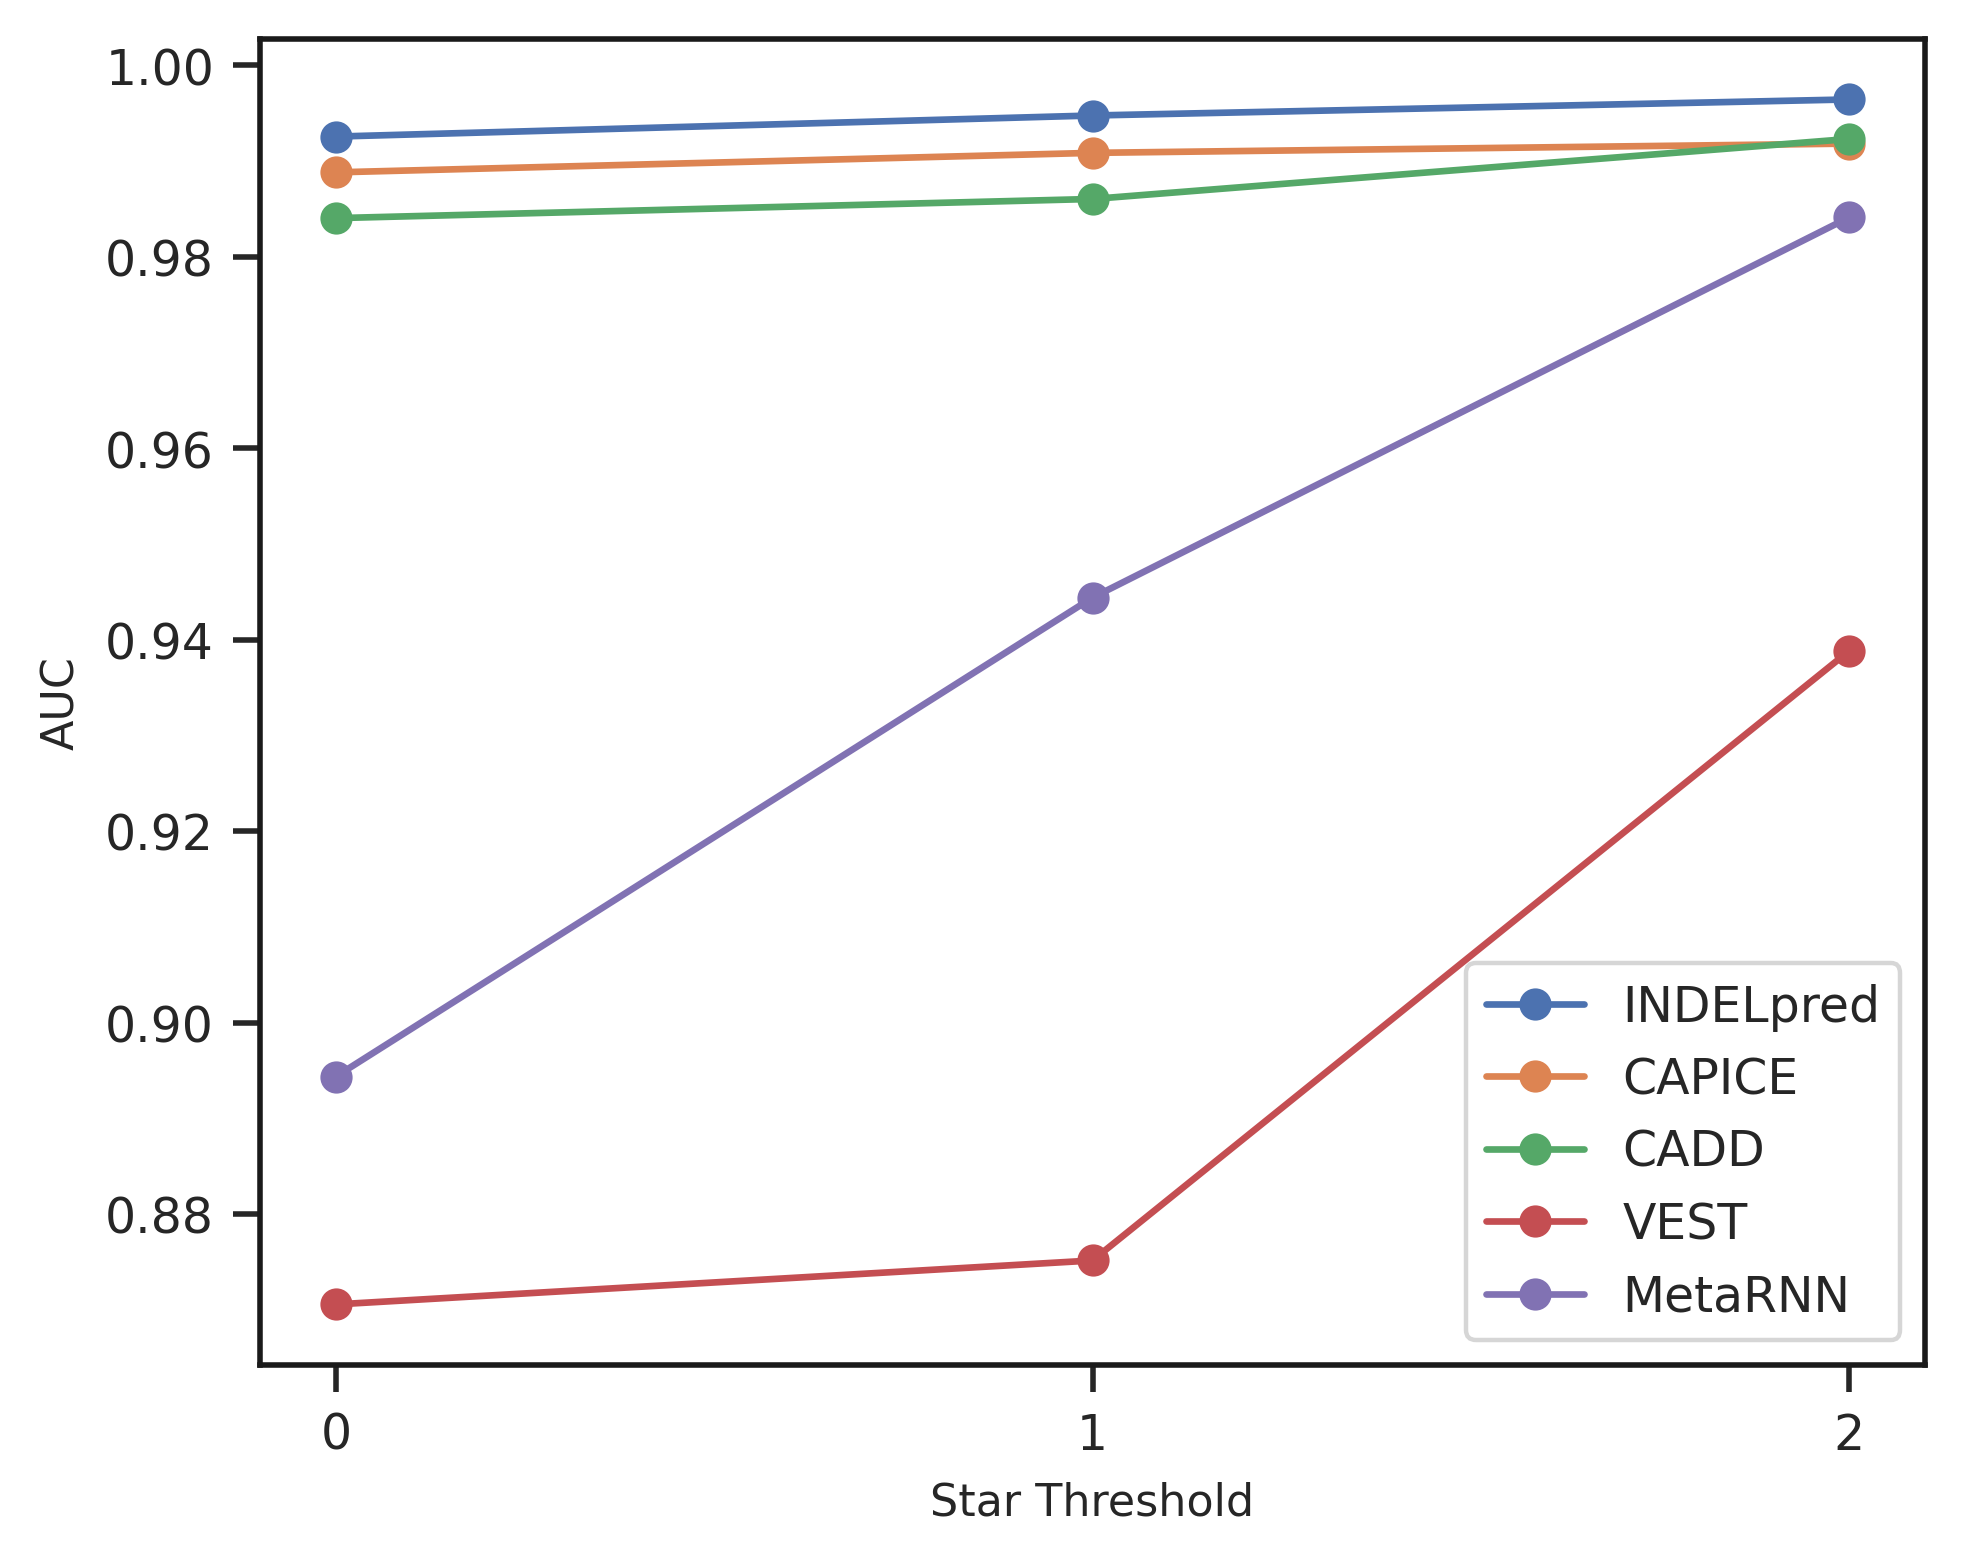

In [7]:
scores = ['INDELpred', 'CAPICE', 'CADD', 'VEST', 'MetaRNN']
star_thresholds = [0, 1, 2]
# star_thresholds = [1, 2, 3]

def calculate_auc_for_star_threshold(data, score_column, tag_column, star_threshold):
    filtered_data = data[data['star'] >= star_threshold].dropna(subset=[score_column, tag_column])
    
    if len(filtered_data) > 0:
        fpr, tpr, _ = roc_curve(filtered_data[tag_column], filtered_data[score_column])
        return auc(fpr, tpr)
    else:
        return np.nan

auc_results = {score: [] for score in scores}

# calculate AUC
for score in scores:
    for threshold in star_thresholds:
        auc_val = calculate_auc_for_star_threshold(data, score, 'tag', threshold)
        auc_results[score].append(auc_val)

plt.figure(figsize=(5, 4))

for score, auc_values in auc_results.items():
    plt.plot(star_thresholds, auc_values, marker='o', label=score)
    print(score, star_thresholds, auc_values)

plt.xticks(star_thresholds)
plt.xlabel('Star Threshold', fontsize=8)
plt.ylabel('AUC', fontsize=8)
plt.legend()
plt.tight_layout()
plt.savefig(f"../final_fig/{dataset}_star_line_{loca}.pdf", format="pdf", dpi=1000, bbox_inches='tight')
plt.show()


star            1      2     3    None
INDELpred  7812.0  131.0  10.0     0.0
CAPICE     7812.0  131.0  10.0     0.0
CADD       7812.0  131.0  10.0     0.0
VEST       4853.0   80.0   7.0  3013.0
MetaRNN     632.0   22.0   0.0  7299.0


<Figure size 1600x1600 with 0 Axes>

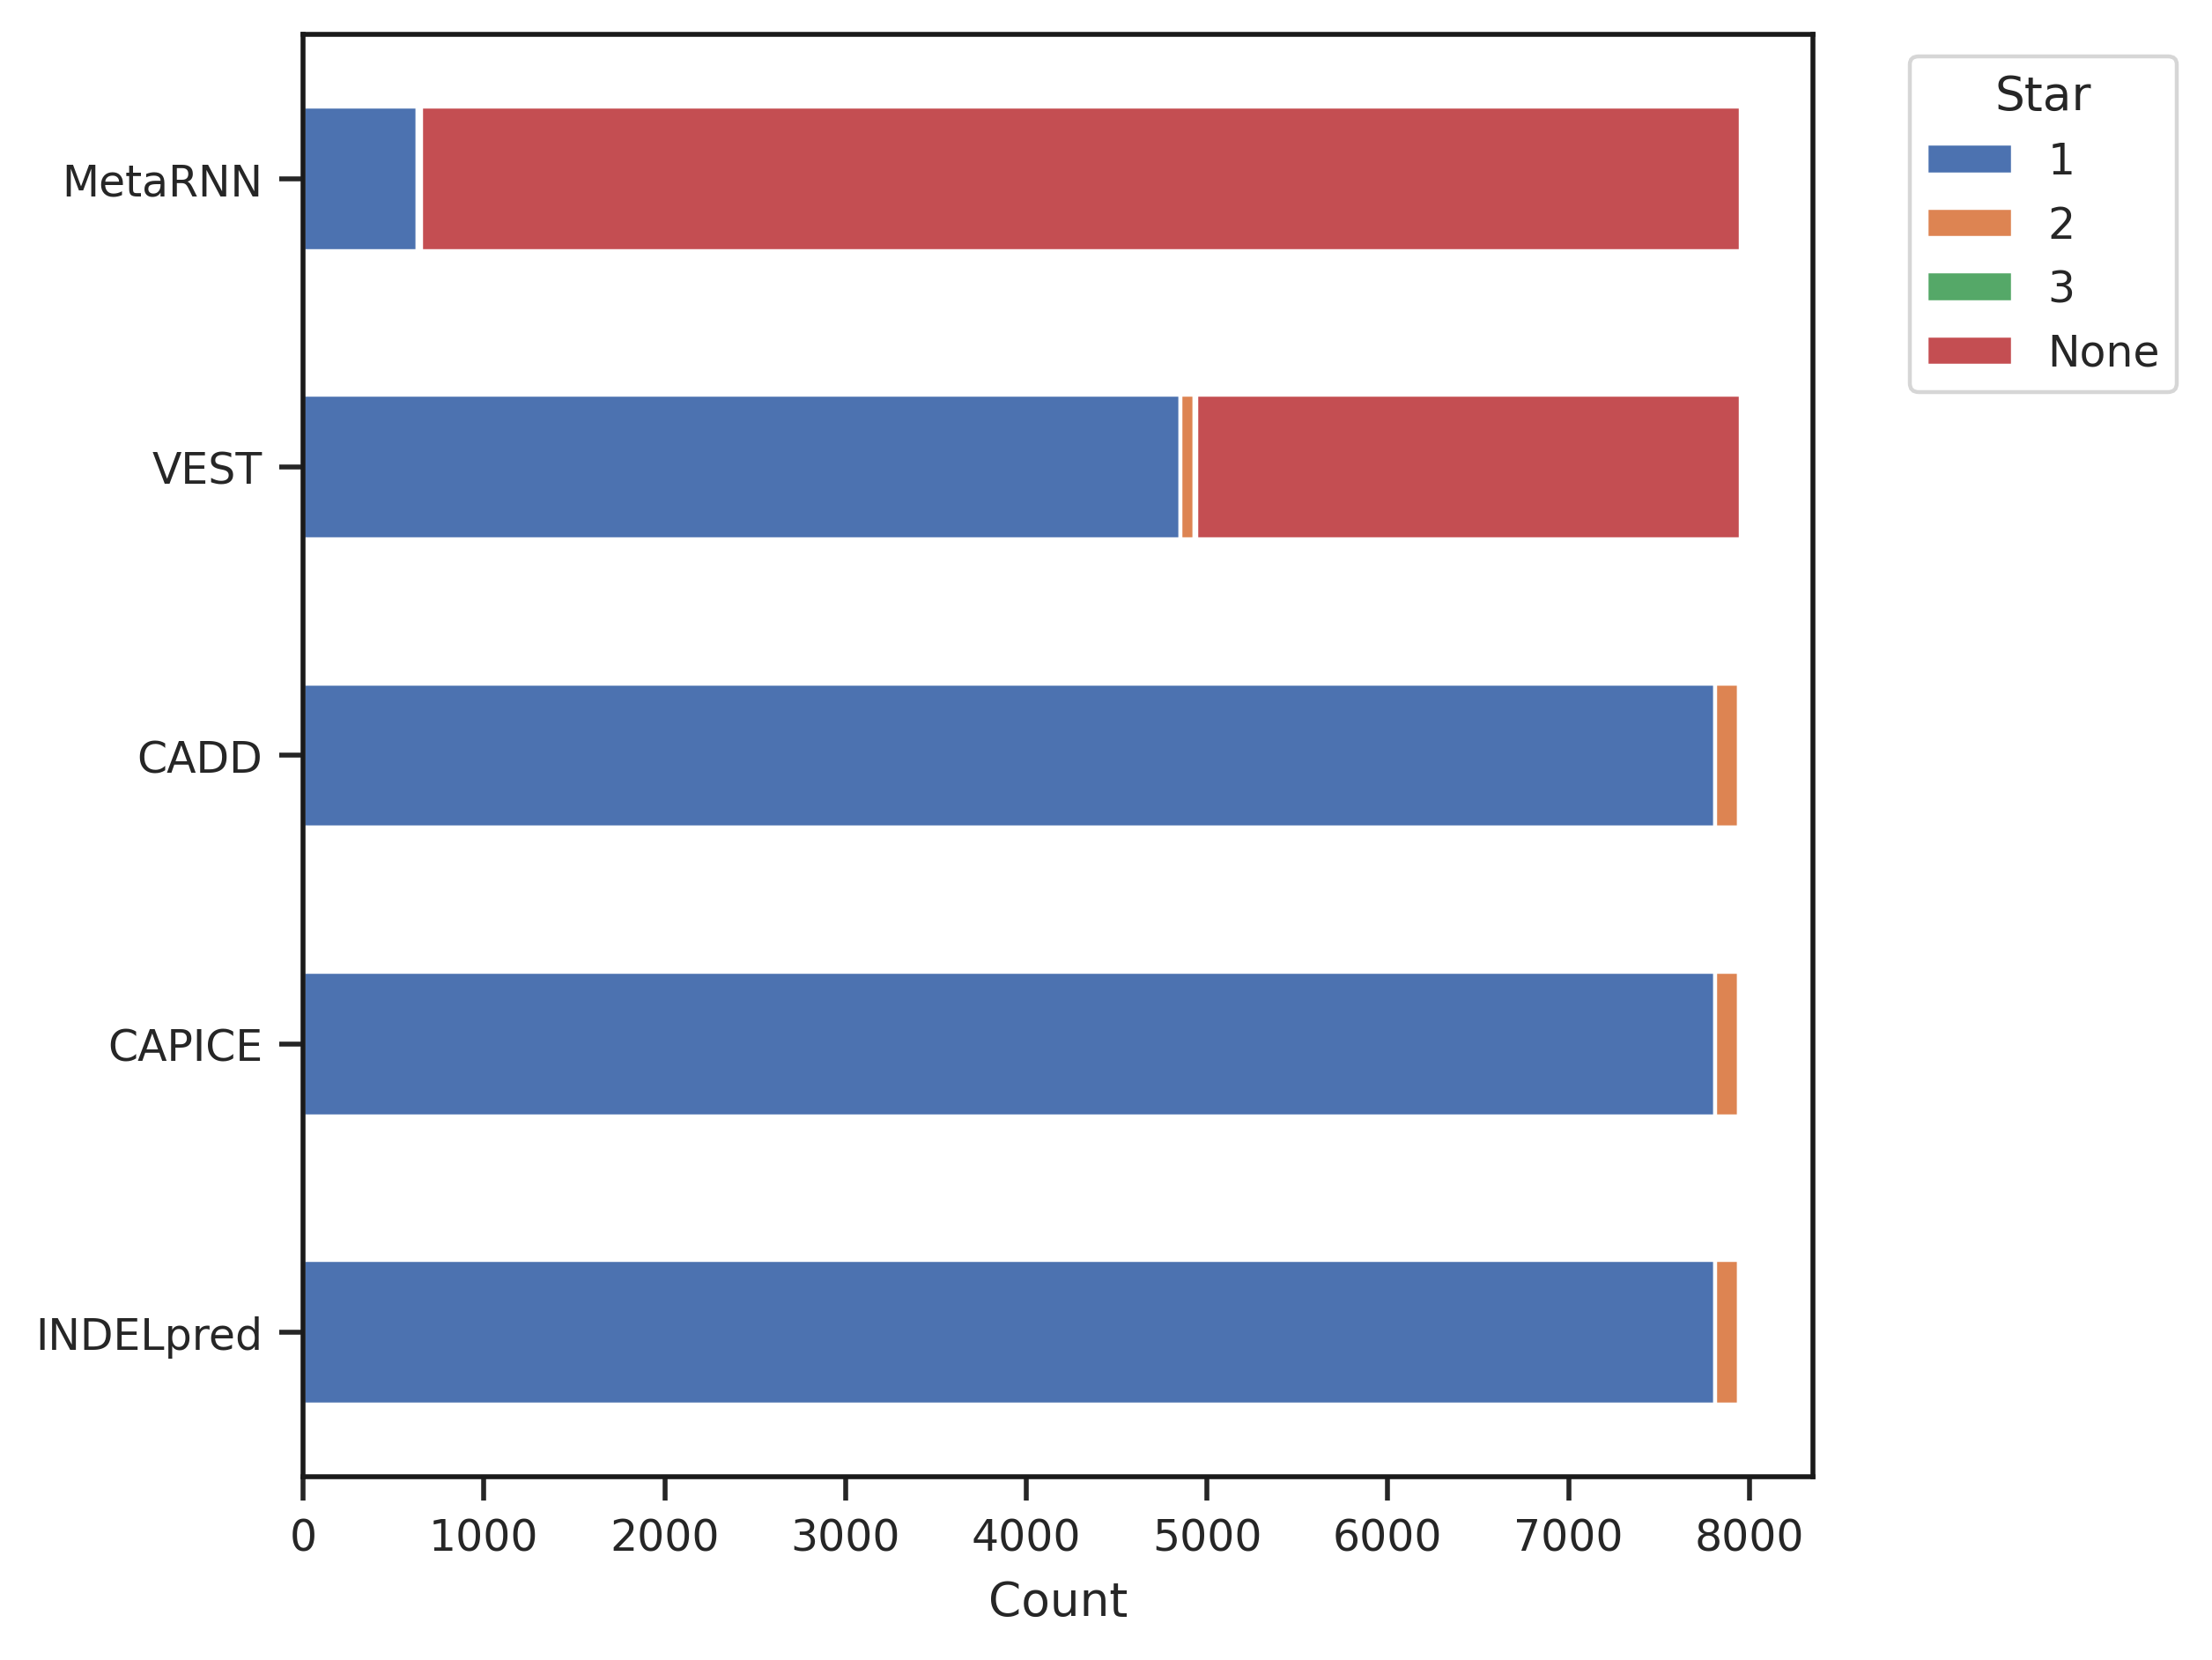

In [38]:
# count of vaiants with star threshold
method_columns = ['INDELpred', 'CAPICE', 'CADD', 'VEST', 'MetaRNN']
counts = data.groupby('star')[method_columns].count()

counts.loc['None',:] = data[method_columns].isna().groupby(data['star']).sum().sum()

counts = counts.T

plt.figure(figsize=(4, 4))
colors = sns.color_palette()[0:4] + ['gray']
counts.plot(kind='barh', stacked=True, color=colors)
print(counts)

plt.xlabel('Count')
plt.legend(title='Star', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig(f"../final_fig/{dataset}_star_bar_{loca}.pdf", format="pdf", dpi=1000, bbox_inches='tight')
plt.show()


In [55]:
counts.to_csv(f"../table/{dataset}_star_counts_{loca}.csv", header=None)

In [64]:
data['Func.refGene'].value_counts()

exonic        33415
intronic      14154
splicing        868
ncRNA           557
UTR             269
stream          108
intergenic       14
Name: Func.refGene, dtype: int64

In [36]:
roc_auc_score(data['tag'], data['INDELpred'])

0.9925696692241646

In [34]:
cleaned_data = data.dropna(subset=['INDELpred', 'tag'])
cleaned_data = cleaned_data[cleaned_data['Func.refGene'] == "exonic"]
auc_score = roc_auc_score(cleaned_data['tag'], cleaned_data['INDELpred'])
Find_Optimal_Cutoff(cleaned_data['tag'], cleaned_data['INDELpred'])

0.96203925975246

In [38]:
cleaned_data = data.dropna(subset=['CAPICE', 'tag'])
# cleaned_data = cleaned_data[cleaned_data['Func.refGene'] == "exonic"]
auc_score = roc_auc_score(cleaned_data['tag'], cleaned_data['CAPICE'])
# Find_Optimal_Cutoff(cleaned_data['tag'], cleaned_data['CAPICE'])
auc_score

0.9888319724703508

In [31]:
def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)

    optimal_threshold = threshold[np.argmax(tpr - fpr)]

    return optimal_threshold

In [29]:
auc_results_separate.dropna(subset=['Func.refGene']).set_index('Func.refGene')[[s for s in scores]]

,INDELpred,CAPICE,CADD,VEST,MetaRNN
Func.refGene,,,,,
intronic,0.741404,0.890283,0.784854,0.947368,NaN
exonic,0.941927,0.960251,0.890079,0.878527,0.893809
splicing,0.692830,0.987798,0.967660,0.659128,1.000000
UTR,0.812951,0.896334,0.660306,NaN,NaN
ncRNA,0.804878,0.972326,0.754964,1.000000,NaN
stream,0.976190,0.982892,0.189242,NaN,NaN
intergenic,0.844444,0.577778,0.550000,NaN,NaN


# heatmap

In [6]:
data['MultOf3'] = (data['length'] % 3 == 0).astype(int)

In [7]:
from sklearn.metrics import (roc_curve, recall_score, matthews_corrcoef, cohen_kappa_score,
                            precision_recall_curve, auc, average_precision_score, 
                            f1_score, balanced_accuracy_score, precision_score)

In [8]:

features = ['AF', 'Length', 'MultOf3', 'TumorGeneType', 'SameGene']
scores = ['MetaRNN', 'VEST','CADD','CAPICE', 'INDELpred']

results_separate = []
sub_counts = pd.DataFrame(columns=['Score', 'Feature', 'ValidRows'])

for feature in features:
    for value in data[feature].unique():
        group = data[data[feature] == value]
        group_results = {feature: value}
        
        #For each combination, calculate the AUROC value associated with the 'tag' feature
        for score in scores:
            valid_rows = group[[score, 'tag']].dropna()
            row_df = pd.DataFrame({'Score': [score], 'Feature': [value], 'ValidRows': [len(valid_rows)]})
            sub_counts = pd.concat([sub_counts, row_df], ignore_index=True)

            # print(f"{score},{value}:{len(valid_rows)}")
            if len(valid_rows) > 1 and len(valid_rows['tag'].unique()) > 1:
                auc = roc_auc_score(valid_rows['tag'], valid_rows[score])
                # auc = average_precision_score(valid_rows['tag'], valid_rows[score])
            else:
                auc = None
            group_results[score] = auc
        
        results_separate.append(group_results)
        
pivot_df = sub_counts.pivot(index='Score', columns='Feature', values='ValidRows')
auc_results_separate = pd.DataFrame(results_separate)
auc_results_separate.head()


,AF,MetaRNN,VEST,CADD,CAPICE,INDELpred,Length,MultOf3,TumorGeneType,SameGene
0,0,0.923300,0.856798,0.984169,0.988905,0.992829,NaN,NaN,NaN,NaN
1,>0.01,0.334615,0.422854,0.827746,0.638703,0.895747,NaN,NaN,NaN,NaN
2,0-0.001,0.661585,0.783005,0.967088,0.965867,0.988441,NaN,NaN,NaN,NaN
3,0.001-0.01,0.365558,0.641584,0.907339,0.865308,0.943565,NaN,NaN,NaN,NaN
4,NaN,0.893908,0.859823,0.987958,0.991058,0.994655,0-10,NaN,NaN,NaN


In [30]:
pivot_df

Feature,0,1,0,0-0.001,0-10,0.001-0.01,10-20,20-50,>0.01,>50,ONC,Other,TSG,difference,same
Score,,,,,,,,,,,,,,,
CADD,45081,4289,45163,1371,44908,1307,2690,1455,1529,317,2112,38141,9117,47658,1712
CAPICE,45090,4291,45174,1371,44911,1307,2691,1456,1529,323,2112,38148,9121,47669,1712
INDELpred,45094,4291,45178,1371,44914,1307,2692,1456,1529,323,2112,38152,9121,47673,1712
MetaRNN,134,1584,1374,94,1082,155,332,304,95,0,155,1284,279,1672,46
VEST,31481,1828,32599,304,30399,250,1764,940,156,206,1301,24740,7268,32164,1145


In [12]:
pivot_df.to_csv(f"ClinVar_sub_counts_{loca}.csv")

In [9]:
auc_results_separate = auc_results_separate[~(auc_results_separate['TumorGeneType'] == 'Other')]

In [10]:
import matplotlib.gridspec as gridspec

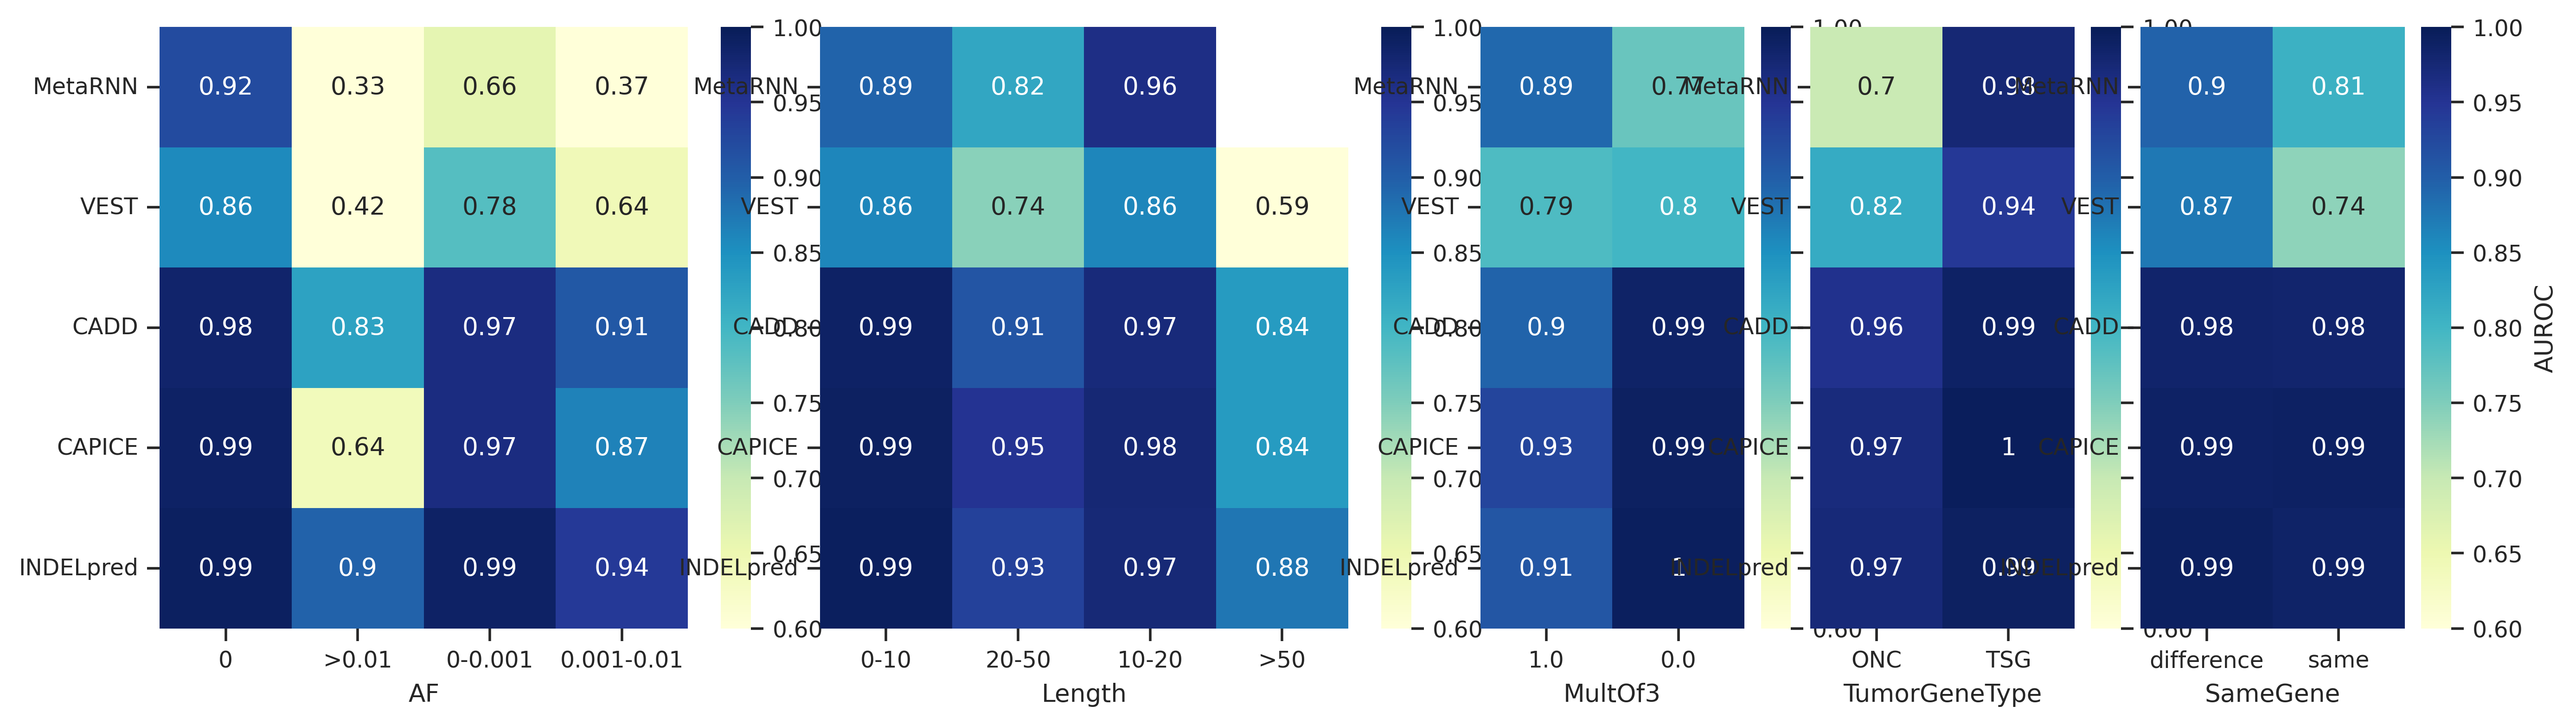

In [12]:
fig = plt.figure(figsize=(sum([len(auc_results_separate.dropna(subset=[feature])) for feature in features]), 4))

gs = gridspec.GridSpec(1, len(features), width_ratios=[len(auc_results_separate.dropna(subset=[feature])) for feature in features], wspace=0)

for i, feature in enumerate(features):
    subset = auc_results_separate.dropna(subset=[feature]).set_index(feature)[[s for s in scores]]
    
    ax = fig.add_subplot(gs[i])
    sns.heatmap(subset.T, annot=True, cmap='YlGnBu', cbar_kws={'label': 'AUROC'}, vmax=1, vmin=0.6, ax=ax)
    ax.set_yticklabels(ax.get_yticklabels(), rotation='horizontal')
    ax.set_xticklabels(ax.get_xticklabels(), rotation='horizontal')
                
plt.tight_layout()
plt.savefig(f"ClinVar_sub_{loca}.pdf", format="pdf", dpi=1000, bbox_inches='tight')
plt.show()
